In [99]:
import numpy as np
import torch
import csv
import re
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [100]:
# Load the data
filename = "archive/IMDB Dataset.csv"
sample_data = []
file = open(filename, encoding="utf8")
csv_reader = csv.reader(file)
for row in csv_reader:
    sample_data.append(row)
file.close()

In [101]:
X_Values = []
Y_Values = []

In [102]:
for i in range(1, len(sample_data)):
    X_Values.append(sample_data[i][0])
    Y_Values.append(sample_data[i][1])

In [103]:
# convert the Y_Values to 0 and 1
for i in range(len(Y_Values)):
    if Y_Values[i] == "positive":
        Y_Values[i] = 1
    else:
        Y_Values[i] = 0

In [104]:
# convert both arrays to numpy arrays
X_Values = np.array(X_Values)
Y_Values = np.array(Y_Values)

In [105]:
# Removing the unwanted Tags.
X_Values = np.array([re.sub('<.*?>', ' ', data) for data in X_Values])
# Removing the special characters.
X_Values = np.array([re.sub('[^a-zA-Z0-9\s]', ' ', data) for data in X_Values])
# Removing the extra spaces.
X_Values = np.array([' '.join(data.split()) for data in X_Values])

In [106]:
# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_Values, Y_Values, test_size=0.2, random_state=42)

In [107]:
# Tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_features = 10000
maxlen = 200
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)
x_train_pad = pad_sequences(x_train, maxlen=maxlen)
x_test_pad = pad_sequences(x_test, maxlen=maxlen)


In [108]:
# Create a custom dataset
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [109]:
# Create the dataloaders
train_dataset = SentimentDataset(x_train_pad, y_train)
test_dataset = SentimentDataset(x_test_pad, y_test)

In [110]:
class RNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [111]:
# Hyperparameters
input_size = max_features
embedding_dim = 128
hidden_size = 100
num_layers = 5
output_size = 1
learning_rate = 0.001
num_epochs = 50
batch_size = 64

In [112]:
# Initialize the model
model = RNN(input_size, embedding_dim, hidden_size, num_layers, output_size).to(device)
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [113]:
LossScore = []

In [114]:
# Train the model
for epoch in range(num_epochs):
    for i in range(0, len(train_dataset), batch_size):
        x_batch, y_batch = train_dataset[i:i+batch_size]
        x_batch = torch.tensor(x_batch).to(device).long()
        y_batch = torch.tensor(y_batch).to(device).float()

        # Forward pass
        outputs = model(x_batch).squeeze()  # Squeeze the output
        loss = criterion(outputs, y_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataset)//batch_size}], Loss: {loss.item():.4f}")
    LossScore.append(loss.item())

Epoch [1/50], Step [39937/625], Loss: 0.5866
Epoch [2/50], Step [39937/625], Loss: 0.6805
Epoch [3/50], Step [39937/625], Loss: 0.5792
Epoch [4/50], Step [39937/625], Loss: 0.5238
Epoch [5/50], Step [39937/625], Loss: 0.5845
Epoch [6/50], Step [39937/625], Loss: 0.4792
Epoch [7/50], Step [39937/625], Loss: 0.4400
Epoch [8/50], Step [39937/625], Loss: 0.4384
Epoch [9/50], Step [39937/625], Loss: 0.4138
Epoch [10/50], Step [39937/625], Loss: 0.4279
Epoch [11/50], Step [39937/625], Loss: 0.5137
Epoch [12/50], Step [39937/625], Loss: 0.4358
Epoch [13/50], Step [39937/625], Loss: 0.4107
Epoch [14/50], Step [39937/625], Loss: 0.3829
Epoch [15/50], Step [39937/625], Loss: 0.4011
Epoch [16/50], Step [39937/625], Loss: 0.3457
Epoch [17/50], Step [39937/625], Loss: 0.2837
Epoch [18/50], Step [39937/625], Loss: 0.2484
Epoch [19/50], Step [39937/625], Loss: 0.3051
Epoch [20/50], Step [39937/625], Loss: 0.2601
Epoch [21/50], Step [39937/625], Loss: 0.2595
Epoch [22/50], Step [39937/625], Loss: 0.20

In [115]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i in range(0, len(test_dataset), batch_size):
        x_batch, y_batch = test_dataset[i:i+batch_size]
        x_batch = torch.tensor(x_batch).to(device).long()
        y_batch = torch.tensor(y_batch).to(device).float()

        outputs = model(x_batch).squeeze()  # Squeeze the output
        predicted = torch.round(torch.sigmoid(outputs))

        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    print(f"Accuracy: {100*correct/total:.4f}")

Accuracy: 77.5900


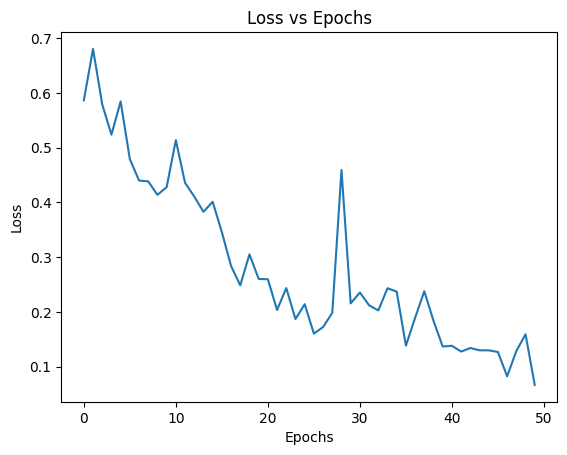

In [116]:
# plotting the loss graph
import matplotlib.pyplot as plt
plt.plot(LossScore)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()